# Timeseries

This notebook is part of the course called [Effective Pandas](https://github.com/TomAugspurger/effective-pandas).

Pandas started out in the financial world, so naturally it has strong timeseries support.



In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's grab some stock data for Goldman Sachs:

In [25]:
ts = pd.read_csv('sample_data2.csv', index_col=['Date'], parse_dates=True, infer_datetime_format=True)
print(ts.dtypes)
print(ts.index)
ts.head()

69614    float64
69618    float64
71104    float64
dtype: object
DatetimeIndex(['1980-07-01', '1980-07-02', '1980-07-03', '1980-07-04',
               '1980-07-05', '1980-07-06', '1980-07-07', '1980-07-08',
               '1980-07-09', '1980-07-10',
               ...
               '2017-06-21', '2017-06-22', '2017-06-23', '2017-06-24',
               '2017-06-25', '2017-06-26', '2017-06-27', '2017-06-28',
               '2017-06-29', '2017-06-30'],
              dtype='datetime64[ns]', name='Date', length=13514, freq=None)


,69614,69618,71104
Date,,,
1980-07-01,5.838,4.499,339.110
1980-07-02,7.340,4.726,356.320
1980-07-03,6.372,4.379,386.909
1980-07-04,5.852,4.228,413.347
1980-07-05,6.359,4.835,445.836


There isn't a special data-container just for time series in pandas, they're just `Series` or `DataFrame`s with a `DatetimeIndex`.

## Special Slicing

Looking at the elements of `ts.index`, we see that `DatetimeIndex`es are made up of `pandas.Timestamp`s:

In [7]:
ts.index[0]

Timestamp('1980-07-01 00:00:00')

A `Timestamp` is mostly compatible with the `datetime.datetime` class, but much amenable to storage in arrays.

Working with `Timestamp`s can be awkward, so Series and DataFrames with `DatetimeIndexes` have some special slicing rules.
The first special case is *partial-string indexing*. Say we wanted to select all the days in 2006. Even with `Timestamp`'s convenient constructors, it's a pai

In [8]:
ts.loc[pd.Timestamp('2006-01-01'):pd.Timestamp('2006-12-31')].head()

,69614,69618,71104
Date,,,
2006-01-01,NaN,2.620,311.338
2006-01-02,NaN,2.717,282.594
2006-01-03,NaN,2.278,264.637
2006-01-04,NaN,2.401,240.115
2006-01-05,NaN,2.220,251.371


Thanks to partial-string indexing, it's as simple as

In [9]:
ts.loc['2006'].head()

,69614,69618,71104
Date,,,
2006-01-01,NaN,2.620,311.338
2006-01-02,NaN,2.717,282.594
2006-01-03,NaN,2.278,264.637
2006-01-04,NaN,2.401,240.115
2006-01-05,NaN,2.220,251.371


Since label slicing is inclusive, this slice selects any observation where the year is 2006.

The second "convenience" is `__getitem__` (square-bracket) fall-back indexing. I'm only going to mention it here, with the caveat that you should never use it.
DataFrame `__getitem__` typically looks in the column: `ts['2006']` would search `ts.columns` for `'2006'`, not find it, and raise a `KeyError`. But DataFrames with a `DatetimeIndex` catch that `KeyError` and try to slice the index.
If it succeeds in slicing the index, the result like `ts.loc['2006']` is returned.
If it fails, the `KeyError` is re-raised.
This is confusing because in pretty much every other case `DataFrame.__getitem__` works on columns, and it's fragile because if you happened to have a column `'2006'` you *would* get just that column, and no fall-back indexing would occur. Just use `ts.loc['2006']` when slicing DataFrame indexes.


## Special Methods

### Resampling

Resampling is similar to a `groupby`: you split the time series into groups (5-day buckets below), apply a function to each group (`mean`), and combine the result (one row per group).

In [10]:
ts.resample("5d").mean().head()

,69614,69618,71104
Date,,,
1980-07-01,6.3522,4.5334,388.3044
1980-07-06,5.2738,4.0158,370.2596
1980-07-11,4.2348,3.3980,381.2194
1980-07-16,3.8788,3.1452,380.0658
1980-07-21,8.6680,3.7688,443.3132


In [11]:
ts.resample("W").agg(['mean', 'sum']).head()

69614             69618               71104          
                mean     sum      mean     sum        mean       sum
Date                                                                
1980-07-06  6.245000  37.470  4.502833  27.017  383.781667  2302.690
1980-07-13  4.817429  33.722  3.740143  26.181  376.568429  2635.979
1980-07-20  3.929429  27.506  3.180571  22.264  380.082429  2660.577
1980-07-27  8.036571  56.256  3.545000  24.815  452.498143  3167.487
1980-08-03  4.813571  33.695  2.680571  18.764  524.589143  3672.124

You can up-sample to convert to a higher frequency.
The new points are filled with NaNs.

In [13]:
ts.resample("6H").mean().head()

,69614,69618,71104
Date,,,
1980-07-01 00:00:00,5.838,4.499,339.11
1980-07-01 06:00:00,NaN,NaN,NaN
1980-07-01 12:00:00,NaN,NaN,NaN
1980-07-01 18:00:00,NaN,NaN,NaN
1980-07-02 00:00:00,7.340,4.726,356.32


### Rolling / Expanding / EW

These methods aren't unique to `DatetimeIndex`es, but they often make sense with time series, so I'll show them here.

Text(102.375, 0.5, 'Flow (m3/s)')

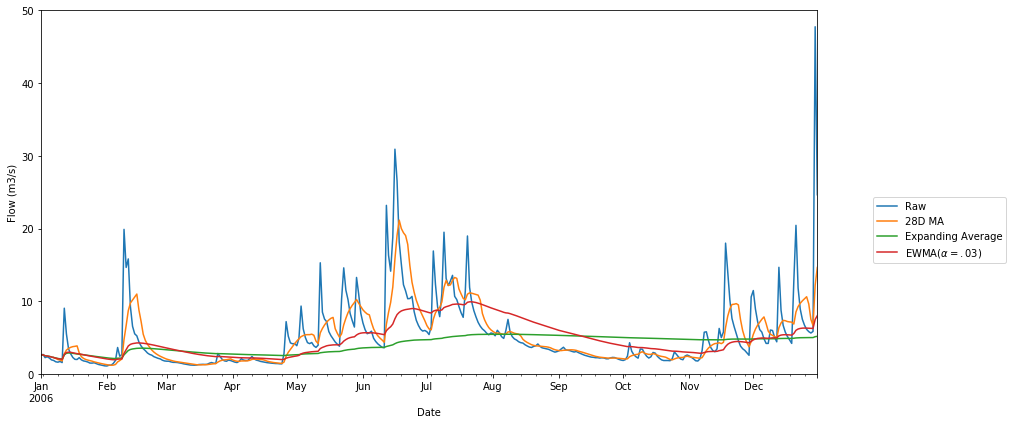

In [24]:
ts1 = ts.loc['2006', '69618']
ts1.plot(label='Raw', figsize=(14, 6), ylim=[0, 50])
ts1.rolling(7).mean().plot(label='28D MA')
ts1.expanding().mean().plot(label='Expanding Average')
ts1.ewm(alpha=0.03).mean().plot(label='EWMA($\\alpha=.03$)')

plt.legend(bbox_to_anchor=(1.25, .5))
plt.tight_layout()
plt.ylabel("Flow (m3/s)")

Each of `.rolling`, `.expanding`, and `.ewm` return a deferred object, similar to a GroupBy.

In [18]:
roll = ts1.rolling(30, center=True)
roll

Rolling [window=30,center=True,axis=0]

Text(92.625, 0.5, 'Flow (m3/s)')

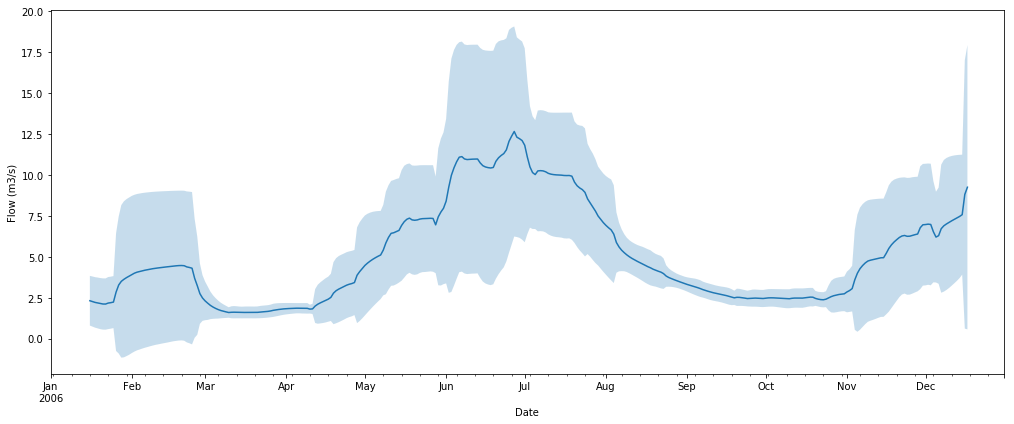

In [20]:
m = roll.agg(['mean', 'std'])
ax = m['mean'].plot(figsize=(14, 6))
ax.fill_between(m.index, m['mean'] - m['std'], m['mean'] + m['std'],
                alpha=.25)
plt.tight_layout()
plt.ylabel("Flow (m3/s)")

## Grab Bag

### Offsets

These are similar to `dateutil.relativedelta`, but works with arrays.

In [21]:
ts.index + pd.DateOffset(months=3, days=-2)

DatetimeIndex(['1980-09-29', '1980-09-30', '1980-10-01', '1980-10-02',
               '1980-10-03', '1980-10-04', '1980-10-05', '1980-10-06',
               '1980-10-07', '1980-10-08',
               ...
               '2017-09-19', '2017-09-20', '2017-09-21', '2017-09-22',
               '2017-09-23', '2017-09-24', '2017-09-25', '2017-09-26',
               '2017-09-27', '2017-09-28'],
              dtype='datetime64[ns]', name='Date', length=13514, freq=None)

### Holiday Calendars

There are a whole bunch of special calendars, useful for traders probabaly.

In [29]:
from pandas.tseries.holiday import USColumbusDay

In [30]:
USColumbusDay.dates('2015-01-01', '2020-01-01')

DatetimeIndex(['2015-10-12', '2016-10-10', '2017-10-09', '2018-10-08',
               '2019-10-14'],
              dtype='datetime64[ns]', freq='WOM-2MON')

### Timezones

Pandas works with `pytz` for nice timezone-aware datetimes.
The typical workflow is

1. localize timezone-naive timestamps to some timezone
2. convert to desired timezone

If you already have timezone-aware Timestamps, there's no need for step one. 

In [23]:
# tz naiive -> tz aware..... to desired UTC
ts.tz_localize('US/Eastern').tz_convert('UTC').head()

,69614,69618,71104
Date,,,
1980-07-01 04:00:00+00:00,5.838,4.499,339.110
1980-07-02 04:00:00+00:00,7.340,4.726,356.320
1980-07-03 04:00:00+00:00,6.372,4.379,386.909
1980-07-04 04:00:00+00:00,5.852,4.228,413.347
1980-07-05 04:00:00+00:00,6.359,4.835,445.836
